In [0]:
NB_EPOCHS = 300
BATCH_SIZE = 256
KFOLD = 5

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import gc, sys
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

tf.__version__

'2.0.0'

##Rebuild train and test sets from input files
1. upload the interactions_train.csv and interactions_test.csv
2. execute next cell

In [4]:
train_matrix = pd.read_csv('./interactions_train_alt.csv').pivot_table(index='u', columns='i', values='rating', dropna=False)
print(f'Shape of train User-Movie-Matrix:\t{train_matrix.shape}')
test_matrix = pd.read_csv('./interactions_test_alt.csv').pivot_table(index='u', columns='i', values='rating', dropna=False)
print(f'Shape of test User-Movie-Matrix:\t{test_matrix.shape}')

Shape of train User-Movie-Matrix:	(6384, 3148)
Shape of test User-Movie-Matrix:	(6384, 3148)


In [0]:
#remplace rating from 0 to 5 to a boolean information : > 3 like (1), otherwise dislike (0)
train_matrix = train_matrix.applymap(lambda x : x if np.isnan(x) else int(x>3))
test_matrix = test_matrix.applymap(lambda x : x if np.isnan(x) else int(x>3))

In [0]:
#replace all missing rating by -1 (as rating are from 0 to 5)
#the -1 will be then used in the model loss function as a mask
train_matrix.fillna(-1, inplace=True)
test_matrix.fillna(-1, inplace=True)

#Build the model

In [0]:
def BuildAEModel(n_recipes, activation=None):
    inputs = tf.keras.layers.Input((n_recipes,))
    #encoded_layer1 = tf.keras.layers.Dense(8192,activation=None, name='Encoder_Layer_1')(inputs)
    #encoded_layer2 = tf.keras.layers.Dense(4096,activation=None, name='Encoder_Layer_2')(inputs)
    #encoded_layer3 = tf.keras.layers.Dense(2048,activation=None, name='Encoder_Layer_3')(encoded_layer2)
    
    embedded = tf.keras.layers.Dense(2,activation=activation, name='embedder')(inputs)
    
    #decoded_layer1 = tf.keras.layers.Dense(2048,activation=None, name='Decoder_Layer_1')(embedded)
    #decoded_layer2 = tf.keras.layers.Dense(4096,activation=None, name='Decoder_Layer_2')(embedded)
    #decoded_layer3 = tf.keras.layers.Dense(8192,activation=None, name='Decoder_Layer_3')(decoded_layer2)
    
    outputs = tf.keras.layers.Dense(n_recipes, activation='linear', name = 'Reconstructor')(embedded)
    
    model = tf.keras.Model(inputs=inputs, outputs = [outputs])
    return model

## define a specific loss function 
- to compare recipes rating for only rated recipes, ie recipes that have values <> -1
- For those recipes, mse will be computed

In [0]:
def customMaskedMSE(ytrue, ypred):
  mask = tf.not_equal(ytrue, -1)
  return tf.keras.backend.mean(tf.keras.backend.square(tf.boolean_mask(ytrue - ypred, mask)))

def customMaskedMAE(ytrue, ypred):
  mask = tf.not_equal(ytrue, -1)
  return tf.keras.backend.mean(tf.keras.backend.abs(tf.boolean_mask(ytrue - ypred, mask)))

## start the training
- Kfold validation

In [9]:
kf = KFold(n_splits=KFOLD, random_state=689)
results = []

for train_index, test_index in kf.split(train_matrix):
  X_train, X_test = train_matrix.iloc[train_index,:], train_matrix.iloc[test_index,:]
  print(X_train.shape, X_test.shape)

  my_model = BuildAEModel(train_matrix.shape[1], 'relu')
  adam = tf.keras.optimizers.Adam(0.001)
  my_model.compile('adam',loss=customMaskedMSE)

  my_model.fit(X_train.values, X_train.values,
                    epochs=NB_EPOCHS, batch_size=BATCH_SIZE, verbose = 0)
  results.append(my_model.evaluate(X_test.values, X_test.values, batch_size=BATCH_SIZE, verbose = 0))
  print(results[-1])

print('CV score is :', np.mean(results))


(5107, 3148) (1277, 3148)
0.06568355078261255
(5107, 3148) (1277, 3148)
0.06950963366727111
(5107, 3148) (1277, 3148)
0.07242768221682838
(5107, 3148) (1277, 3148)
0.07259674022556191
(5108, 3148) (1276, 3148)
0.07340789161225471
CV score is : 0.07072509970090572


In [10]:
#training of model on full train set
my_model = BuildAEModel(train_matrix.shape[1], 'relu')
my_model.summary()
adam = tf.keras.optimizers.Adam(0.001)
my_model.compile('adam',loss=customMaskedMSE)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3148)]            0         
_________________________________________________________________
embedder (Dense)             (None, 2)                 6298      
_________________________________________________________________
Reconstructor (Dense)        (None, 3148)              9444      
Total params: 15,742
Trainable params: 15,742
Non-trainable params: 0
_________________________________________________________________


In [11]:
hist = my_model.fit(train_matrix.values, train_matrix.values,
                    epochs=NB_EPOCHS, batch_size=BATCH_SIZE)

Train on 6384 samples
Epoch 1/300
6384/6384 [==============================] - 1s 86us/sample - loss: 0.8507
Epoch 2/300
6384/6384 [==============================] - 0s 30us/sample - loss: 0.4261
Epoch 3/300
6384/6384 [==============================] - 0s 30us/sample - loss: 0.1445
Epoch 4/300
6384/6384 [==============================] - 0s 30us/sample - loss: 0.0738
Epoch 5/300
6384/6384 [==============================] - 0s 31us/sample - loss: 0.0637
Epoch 6/300
6384/6384 [==============================] - 0s 30us/sample - loss: 0.0625
Epoch 7/300
6384/6384 [==============================] - 0s 29us/sample - loss: 0.0622
Epoch 8/300
6384/6384 [==============================] - 0s 29us/sample - loss: 0.0625
Epoch 9/300
6384/6384 [==============================] - 0s 30us/sample - loss: 0.0621
Epoch 10/300
6384/6384 [==============================] - 0s 30us/sample - loss: 0.0622
Epoch 11/300
6384/6384 [==============================] - 0s 29us/sample - loss: 0.0623
Epoch 12/300
6384/6

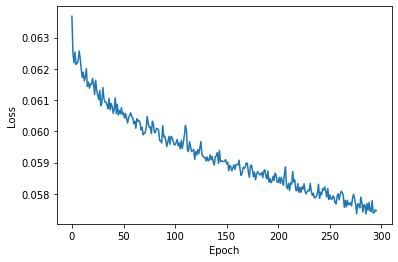

In [12]:
plt.plot(hist.history['loss'][4:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [13]:
#evaluation on the train set
my_model.evaluate(train_matrix.values, train_matrix.values, verbose=1)

6384/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.062272937394174416

In [14]:
#evaluation on the test set
my_model.evaluate(train_matrix.values, test_matrix.values, verbose=1)

6384/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.08069490287499619

# Save model on google drive for local evaluation

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
my_model.save("/content/drive/My Drive/ML/ae_v2.h5",include_optimizer=False)

##compare predictions with test data for a user
This is for quick analysis, refer to notebook DisplayReco for better analysis

In [17]:
#getting user train ratings
id = 24240
#id=33
user = train_matrix[train_matrix.index == id].T
user_ratings_train = user[user[id]!=-1].T

#getting user test ratings
user = test_matrix[test_matrix.index == id].T
user_ratings_test = user[user[id]!=-1].T

display(user_ratings_train)
display(user_ratings_test)

i,74195,92594,118107,143788,149471,166665,171697
u,,,,,,,
24240,1.0,1.0,1.0,1.0,1.0,0.0,1.0


i,97448
u,
24240,1.0


In [18]:
#get predictions from model
user_train = train_matrix[train_matrix.index == id].values
preds = my_model.predict(user_train, verbose=1)
preds = pd.DataFrame(preds, columns = train_matrix.columns)

1/1 [==============================] - 0s 29ms/sample


In [19]:
#user mse
np.square(preds[user_ratings_train.columns].values - user_ratings_train.values).mean()

0.12197578592625595

In [20]:
#user prediction for train recipes
preds[user_ratings_train.columns]

i,74195,92594,118107,143788,149471,166665,171697
0,0.89388,0.866235,0.911222,0.992514,0.932327,0.895674,0.900363


In [21]:
#user prediction for test recipes
preds[user_ratings_test.columns]

i,97448
0,0.927401


In [22]:
#top 10 recipes
reco = preds[set(preds.columns) - set (user_ratings_train.columns)].T.sort_values([0],ascending=False)
reco_top10 = reco.head(10)
display(reco_top10)
reco_top10.index

,0
i,
74196,1.033372
131487,1.013900
33572,1.011029
57785,1.009331
69708,1.008552
131887,1.008183
95428,1.008074
159031,1.007907
107040,1.007902


Int64Index([74196, 131487, 33572, 57785, 69708, 131887, 95428, 159031, 107040,
            1825],
           dtype='int64', name='i')

In [23]:
#get positions of user test recipes in recommandation from autoencoder
for recipe in user_ratings_test.columns:
  print('recipe ID :', recipe, 'position in reco :', str(reco.index.get_loc(recipe)) + '/' + str(len(train_matrix)))


recipe ID : 97448 position in reco : 1269/6384


## output index for local analysis 
(data source too big for colab)

In [24]:
#the train recipes from user
print(user_ratings_train.columns)
#the top 10 recommanded recipes
print(reco_top10.index)

Int64Index([74195, 92594, 118107, 143788, 149471, 166665, 171697], dtype='int64', name='i')
Int64Index([74196, 131487, 33572, 57785, 69708, 131887, 95428, 159031, 107040,
            1825],
           dtype='int64', name='i')
